In [56]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import *
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale, StandardScaler
from sklearn.metrics.pairwise import euclidean_distances
from catboost import CatBoostClassifier, Pool
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import scipy as sc
from sklearn.metrics import roc_auc_score,roc_curve,average_precision_score, auc,precision_recall_curve, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
import math
import numpy as np

### What are trying to solve?
Identify bookings which violate safety restrictions based on telematics data from the ride.

#### What kind of data do we have?

We have acceleration and gyroscope readings from all 3 axis, the speed, reading of bearing and accuracy of the same.

In [2]:
##Loading files function takes in input location of files

def load_data_files(file_directory):
    file_list=os.listdir(file_directory+'features/')
    file_list_full_path=list(map(lambda x: file_directory+'features/'+x,file_list))
    labels=pd.read_csv(file_directory+'labels/'+os.listdir(file_directory+'labels/')[0])
    full_data = pd.concat([pd.read_csv(f) for f in file_list_full_path ],axis=0)
    return full_data,labels

In [3]:
safety_full_data,label_data=load_data_files("/Users/debaryadutta/Downloads/safety/")

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


We have data on 

In [105]:
booking_train,booking_test=train_test_split(bookingids, test_size=0.33, random_state=42)


How does the accuracy distribution look like?

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


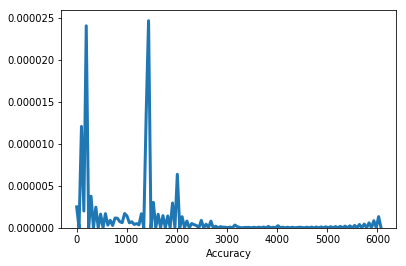

In [106]:
sns.distplot(safety_full_data['Accuracy'],hist = False, kde = True,
                 kde_kws = {'linewidth': 3})

##### How bad is the class imbalance? 

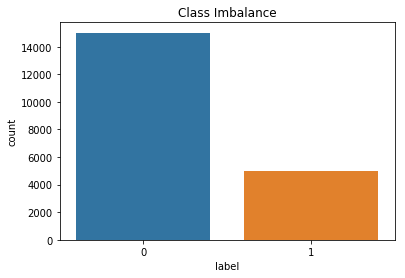

In [110]:
sns.countplot(label_data['label'])
plt.title('Class Imbalance')
plt.show()

How does a trajectory of bad ride vs a good ride look?

In [115]:
bad_bookings=label_data[label_data['label']==1]
good_bookings=label_data[label_data['label']==0]
bad_booking_id=bad_bookings['bookingID']
good_booking_id=bad_bookings['bookingID']
bad_booking_id_sample=bad_booking_id.sample(n=10)
good_booking_id_sample=good_booking_id.sample(n=10)

In [ ]:
safety_full_data

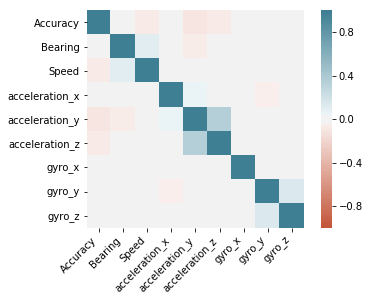

In [71]:
corr = training_data.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);


In [85]:
## Lets us transform (x,y,z) to (R,phi,theta)

def transform_angle(row): 
    x=row['acceleration_x']
    y=row['acceleration_y']
    z=row['acceleration_z']
    phi = math.atan(y/z)
    theta = math.atan(-x/(y*math.sin(phi)+z*math.cos(phi)))
    #psi = math.atan((mz*math.sin(phi) - my*math.cos(phi))/(mx*math.cos(theta) + my*math.sin(theta)*math.sin(phi) + mz*math.sin(theta)*math.cos(phi)))

    Rx = np.array([[1,0,0], [0,math.cos(phi),math.sin(phi)], [0,-math.sin(phi),math.cos(phi)]])
    Ry = np.array([[math.cos(theta),0,-math.sin(theta)], [0,1,0], [math.sin(theta),0,math.cos(theta)]])
    Rz = np.array([[math.cos(phi),math.sin(phi),0], [-math.sin(phi),math.cos(phi),0], [0,0,1]])

    R = Rx.dot(Ry).dot(Rz)
    transform_vec=R.dot([x,y,z])
    
    return transform_vec,np.linalg.norm(transform_vec),phi,theta


def transform_angle_gyro(row): 
    x=row['gyro_x']
    y=row['gyro_y']
    z=row['gyro_z']
    phi = math.atan(y/z)
    theta = math.atan(-x/(y*math.sin(phi)+z*math.cos(phi)))
    #psi = math.atan((mz*math.sin(phi) - my*math.cos(phi))/(mx*math.cos(theta) + my*math.sin(theta)*math.sin(phi) + mz*math.sin(theta)*math.cos(phi)))

    Rx = np.array([[1,0,0], [0,math.cos(phi),math.sin(phi)], [0,-math.sin(phi),math.cos(phi)]])
    Ry = np.array([[math.cos(theta),0,-math.sin(theta)], [0,1,0], [math.sin(theta),0,math.cos(theta)]])
    Rz = np.array([[math.cos(phi),math.sin(phi),0], [-math.sin(phi),math.cos(phi),0], [0,0,1]])

    R = Rx.dot(Ry).dot(Rz)
    transform_vec=R.dot([x,y,z])
    
    return transform_vec,np.linalg.norm(transform_vec),phi,theta

In [232]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_


In [257]:
safety_full_data['transform_vec_acc']=safety_full_data[['acceleration_x','acceleration_y','acceleration_z']].apply(transform_angle,axis=1)

## Trasnform (x,y,z) to R,phi, theta 

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """


In [243]:
safety_full_data['transform_vec_gyro']=safety_full_data[['gyro_x','gyro_y','gyro_z']].apply(transform_angle_gyro,axis=1)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in double_scalars
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


#### What features do we use for the model?

We use min, max, mean and median absolute value for R, phi and theta.

In [245]:
aggregations={'R_acc':
{
'abs_min_acc_R':lambda x:min(abs(x)),
'abs_max_acc_R':lambda x:max(abs(x)),
'abs_mean_acc_R':lambda x:mean(abs(x)),
'abs_median_acc_R':lambda x:median(abs(x))

},
'phi_acc':             
{
'abs_min_acc_phi':lambda x:min(abs(x)),
'abs_max_acc_phi':lambda x:max(abs(x)),
'abs_mean_acc_phi':lambda x:mean(abs(x)),
'abs_median_acc_phi':lambda x:median(abs(x))

},
'theta_acc':             
{
'abs_min_acc_theta':lambda x:min(abs(x)),
'abs_max_acc_theta':lambda x:max(abs(x)),
'abs_mean_acc_theta':lambda x:mean(abs(x)),
'abs_median_acc_theta':lambda x:median(abs(x))

}
              
}


aggregations_gyro={'R_gyro':
{
'abs_min_gyro_R':lambda x:min(abs(x)),
'abs_max_gyro_R':lambda x:max(abs(x)),
'abs_mean_gyro_R':lambda x:mean(abs(x)),
'abs_median_gyro_R':lambda x:median(abs(x))

},
'phi_gyro':             
{
'abs_min_gyro_phi':lambda x:min(abs(x)),
'abs_max_gyro_phi':lambda x:max(abs(x)),
'abs_mean_gyro_phi':lambda x:mean(abs(x)),
'abs_median_gyro_phi':lambda x:median(abs(x))

},
'theta_gyro':             
{
'abs_min_gyro_theta':lambda x:min(abs(x)),
'abs_max_gyro_theta':lambda x:max(abs(x)),
'abs_mean_gyro_theta':lambda x:mean(abs(x)),
'abs_median_gyro_theta':lambda x:median(abs(x))

}
                   
}

aggregations_speed={'Speed':
{
'abs_min_speed':lambda x:min(abs(x)),
'abs_max_speed':lambda x:max(abs(x)),
'abs_mean_speed':lambda x:mean(abs(x)),
'abs_median_speed':lambda x:median(abs(x))

},
'Bearing':             
{
'abs_min_bearing':lambda x:min(abs(x)),
'abs_max_bearing':lambda x:max(abs(x)),
'abs_mean_bearing':lambda x:mean(abs(x)),
'abs_median_bearing':lambda x:median(abs(x))

}           
}


In [244]:

acc_data=safety_full_data[['bookingID','transform_vec_acc']]
acc_data_df=pd.DataFrame(acc_data)    
    

In [246]:
acc_data_df[['acc_vec','R_acc','phi_acc','theta_acc']]=pd.DataFrame(acc_data_df.transform_vec_acc.values.tolist(), index= acc_data_df.index)

In [247]:
gyro_data=safety_full_data[['bookingID','transform_vec_gyro']]
gyro_data_df=pd.DataFrame(gyro_data)    
gyro_data_df[['gyro_vec','R_gyro','phi_gyro','theta_gyro']]=pd.DataFrame(gyro_data_df.transform_vec_gyro.values.tolist(), index= gyro_data_df.index)    

In [248]:
acc_full_data_summary= acc_data_df.groupby("bookingID").agg(aggregations)
gyro_full_data_summary= gyro_data_df.groupby("bookingID").agg(aggregations_gyro)
speed_full_data_summary=safety_full_data.groupby("bookingID").agg(aggregations_speed)

In [148]:
acc_full_data_summary.head(10)

R_acc                                                \
          abs_min_acc_R abs_max_acc_R abs_mean_acc_R abs_median_acc_R   
bookingID                                                               
0.0            6.457339     12.988328       9.886164         9.852645   
1.0            6.970526     12.790147       9.862507         9.844748   
2.0            8.234988     13.403410       9.929590         9.877755   
4.0            7.703982     21.053265       9.813434         9.791035   
6.0            7.218154     14.498268       9.918090         9.904142   
7.0            5.525063     14.097100       9.826470         9.789800   
8.0            4.096356     13.513198       9.762028         9.646309   
10.0           4.834261     14.308998       9.550677         9.494390   
11.0           7.651331     13.337435       9.948639         9.877962   
13.0           5.330475     15.174138       9.874082         9.858254   

                  phi_acc                                                      
          abs_min_acc_phi abs_max_acc_phi abs_mean_acc_phi abs_median_acc_phi  
bookingID                                                                      
0.0              0.911776        1.569314         1.394170           1.405383  
1.0              1.004253        1.570083         1.342734           1.345551  
2.0              1.250480        1.570581         1.488111           1.502576  
4.0              1.034536        1.558701         1.300253           1.300061  
6.0              0.903251        1.570263         1.327456           1.328027  
7.0              0.835547        1.568284         1.344421           1.349658  
8.0              1.052442        1.570722         1.387538           1.385312  
10.0             0.947864        1.568467         1.393271           1.404561  
11.0             0.912115        1.570022         1.454374           1.475685  
13.0             0.176538        1.540560         1.100376           1.097603

In [249]:

acc_gyro_full_data_summary=pd.merge(pd.DataFrame(acc_full_data_summary),pd.DataFrame(gyro_full_data_summary),on='bookingID').reset_index()

acc_gyro_speed_full_data_summary=pd.merge(acc_gyro_full_data_summary,speed_full_data_summary,on='bookingID')
fulldataset=pd.merge(label_data,acc_gyro_speed_full_data_summary,on='bookingID')

fulldataset=fulldataset.dropna()


/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:3111: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [250]:
booking_train,booking_test=train_test_split(fulldataset, test_size=0.3, random_state=42)


In [251]:
booking_train_data=booking_train.drop(columns=['bookingID','label'])
booking_train_label=booking_train['label']

In [252]:
booking_test_data=booking_test.drop(columns=['bookingID','label'])
booking_test_label=booking_test['label']

In [258]:
from catboost import CatBoostClassifier
  

model = CatBoostClassifier(iterations=3000, learning_rate=0.05, depth=5,eval_metric='AUC')
# Fit model
model.fit(booking_train_data, booking_train_label)

0:	total: 148ms	remaining: 7m 24s
1:	total: 192ms	remaining: 4m 47s
2:	total: 226ms	remaining: 3m 46s
3:	total: 257ms	remaining: 3m 12s
4:	total: 295ms	remaining: 2m 56s
5:	total: 407ms	remaining: 3m 23s
6:	total: 526ms	remaining: 3m 44s
7:	total: 595ms	remaining: 3m 42s
8:	total: 1.2s	remaining: 6m 38s
9:	total: 1.24s	remaining: 6m 10s
10:	total: 1.27s	remaining: 5m 44s
11:	total: 1.29s	remaining: 5m 22s
12:	total: 1.32s	remaining: 5m 3s
13:	total: 1.37s	remaining: 4m 51s
14:	total: 1.39s	remaining: 4m 37s
15:	total: 1.45s	remaining: 4m 30s
16:	total: 1.49s	remaining: 4m 20s
17:	total: 1.51s	remaining: 4m 10s
18:	total: 1.57s	remaining: 4m 6s
19:	total: 1.67s	remaining: 4m 8s
20:	total: 1.73s	remaining: 4m 5s
21:	total: 1.79s	remaining: 4m 3s
22:	total: 1.84s	remaining: 3m 58s
23:	total: 1.9s	remaining: 3m 55s
24:	total: 1.96s	remaining: 3m 53s
25:	total: 2s	remaining: 3m 48s
26:	total: 2.03s	remaining: 3m 43s
27:	total: 2.08s	remaining: 3m 40s
28:	total: 2.14s	remaining: 3m 39s
29:	t

238:	total: 9.93s	remaining: 1m 54s
239:	total: 9.96s	remaining: 1m 54s
240:	total: 9.98s	remaining: 1m 54s
241:	total: 10s	remaining: 1m 54s
242:	total: 10s	remaining: 1m 53s
243:	total: 10.1s	remaining: 1m 53s
244:	total: 10.1s	remaining: 1m 53s
245:	total: 10.1s	remaining: 1m 53s
246:	total: 10.1s	remaining: 1m 52s
247:	total: 10.2s	remaining: 1m 52s
248:	total: 10.2s	remaining: 1m 52s
249:	total: 10.2s	remaining: 1m 52s
250:	total: 10.2s	remaining: 1m 52s
251:	total: 10.3s	remaining: 1m 51s
252:	total: 10.3s	remaining: 1m 51s
253:	total: 10.3s	remaining: 1m 51s
254:	total: 10.3s	remaining: 1m 51s
255:	total: 10.4s	remaining: 1m 51s
256:	total: 10.4s	remaining: 1m 50s
257:	total: 10.4s	remaining: 1m 50s
258:	total: 10.4s	remaining: 1m 50s
259:	total: 10.5s	remaining: 1m 50s
260:	total: 10.5s	remaining: 1m 50s
261:	total: 10.5s	remaining: 1m 49s
262:	total: 10.5s	remaining: 1m 49s
263:	total: 10.6s	remaining: 1m 49s
264:	total: 10.6s	remaining: 1m 49s
265:	total: 10.6s	remaining: 1m 

472:	total: 18.3s	remaining: 1m 37s
473:	total: 18.3s	remaining: 1m 37s
474:	total: 18.4s	remaining: 1m 37s
475:	total: 18.4s	remaining: 1m 37s
476:	total: 18.4s	remaining: 1m 37s
477:	total: 18.4s	remaining: 1m 37s
478:	total: 18.5s	remaining: 1m 37s
479:	total: 18.5s	remaining: 1m 37s
480:	total: 18.6s	remaining: 1m 37s
481:	total: 18.6s	remaining: 1m 37s
482:	total: 18.6s	remaining: 1m 37s
483:	total: 18.7s	remaining: 1m 36s
484:	total: 18.7s	remaining: 1m 36s
485:	total: 18.7s	remaining: 1m 36s
486:	total: 18.8s	remaining: 1m 36s
487:	total: 18.8s	remaining: 1m 36s
488:	total: 18.8s	remaining: 1m 36s
489:	total: 18.9s	remaining: 1m 36s
490:	total: 18.9s	remaining: 1m 36s
491:	total: 18.9s	remaining: 1m 36s
492:	total: 19s	remaining: 1m 36s
493:	total: 19s	remaining: 1m 36s
494:	total: 19s	remaining: 1m 36s
495:	total: 19.1s	remaining: 1m 36s
496:	total: 19.1s	remaining: 1m 36s
497:	total: 19.2s	remaining: 1m 36s
498:	total: 19.2s	remaining: 1m 36s
499:	total: 19.3s	remaining: 1m 36

706:	total: 26.2s	remaining: 1m 25s
707:	total: 26.3s	remaining: 1m 25s
708:	total: 26.3s	remaining: 1m 24s
709:	total: 26.3s	remaining: 1m 24s
710:	total: 26.4s	remaining: 1m 24s
711:	total: 26.4s	remaining: 1m 24s
712:	total: 26.4s	remaining: 1m 24s
713:	total: 26.5s	remaining: 1m 24s
714:	total: 26.5s	remaining: 1m 24s
715:	total: 26.5s	remaining: 1m 24s
716:	total: 26.6s	remaining: 1m 24s
717:	total: 26.6s	remaining: 1m 24s
718:	total: 26.6s	remaining: 1m 24s
719:	total: 26.7s	remaining: 1m 24s
720:	total: 26.7s	remaining: 1m 24s
721:	total: 26.7s	remaining: 1m 24s
722:	total: 26.7s	remaining: 1m 24s
723:	total: 26.8s	remaining: 1m 24s
724:	total: 26.8s	remaining: 1m 24s
725:	total: 26.8s	remaining: 1m 24s
726:	total: 26.9s	remaining: 1m 23s
727:	total: 26.9s	remaining: 1m 23s
728:	total: 26.9s	remaining: 1m 23s
729:	total: 27s	remaining: 1m 23s
730:	total: 27s	remaining: 1m 23s
731:	total: 27.1s	remaining: 1m 23s
732:	total: 27.1s	remaining: 1m 23s
733:	total: 27.1s	remaining: 1m 

936:	total: 33.9s	remaining: 1m 14s
937:	total: 33.9s	remaining: 1m 14s
938:	total: 33.9s	remaining: 1m 14s
939:	total: 34s	remaining: 1m 14s
940:	total: 34s	remaining: 1m 14s
941:	total: 34s	remaining: 1m 14s
942:	total: 34s	remaining: 1m 14s
943:	total: 34.1s	remaining: 1m 14s
944:	total: 34.1s	remaining: 1m 14s
945:	total: 34.2s	remaining: 1m 14s
946:	total: 34.2s	remaining: 1m 14s
947:	total: 34.2s	remaining: 1m 14s
948:	total: 34.3s	remaining: 1m 14s
949:	total: 34.3s	remaining: 1m 14s
950:	total: 34.3s	remaining: 1m 13s
951:	total: 34.4s	remaining: 1m 13s
952:	total: 34.4s	remaining: 1m 13s
953:	total: 34.4s	remaining: 1m 13s
954:	total: 34.5s	remaining: 1m 13s
955:	total: 34.5s	remaining: 1m 13s
956:	total: 34.5s	remaining: 1m 13s
957:	total: 34.6s	remaining: 1m 13s
958:	total: 34.6s	remaining: 1m 13s
959:	total: 34.6s	remaining: 1m 13s
960:	total: 34.6s	remaining: 1m 13s
961:	total: 34.7s	remaining: 1m 13s
962:	total: 34.7s	remaining: 1m 13s
963:	total: 34.7s	remaining: 1m 13s


1164:	total: 41.2s	remaining: 1m 4s
1165:	total: 41.3s	remaining: 1m 4s
1166:	total: 41.3s	remaining: 1m 4s
1167:	total: 41.3s	remaining: 1m 4s
1168:	total: 41.4s	remaining: 1m 4s
1169:	total: 41.4s	remaining: 1m 4s
1170:	total: 41.4s	remaining: 1m 4s
1171:	total: 41.5s	remaining: 1m 4s
1172:	total: 41.5s	remaining: 1m 4s
1173:	total: 41.5s	remaining: 1m 4s
1174:	total: 41.6s	remaining: 1m 4s
1175:	total: 41.6s	remaining: 1m 4s
1176:	total: 41.6s	remaining: 1m 4s
1177:	total: 41.7s	remaining: 1m 4s
1178:	total: 41.7s	remaining: 1m 4s
1179:	total: 41.8s	remaining: 1m 4s
1180:	total: 41.8s	remaining: 1m 4s
1181:	total: 41.8s	remaining: 1m 4s
1182:	total: 41.9s	remaining: 1m 4s
1183:	total: 41.9s	remaining: 1m 4s
1184:	total: 41.9s	remaining: 1m 4s
1185:	total: 41.9s	remaining: 1m 4s
1186:	total: 42s	remaining: 1m 4s
1187:	total: 42s	remaining: 1m 4s
1188:	total: 42s	remaining: 1m 4s
1189:	total: 42.1s	remaining: 1m 3s
1190:	total: 42.1s	remaining: 1m 3s
1191:	total: 42.1s	remaining: 1m 3

1397:	total: 49.3s	remaining: 56.5s
1398:	total: 49.3s	remaining: 56.4s
1399:	total: 49.3s	remaining: 56.4s
1400:	total: 49.3s	remaining: 56.3s
1401:	total: 49.4s	remaining: 56.3s
1402:	total: 49.4s	remaining: 56.2s
1403:	total: 49.4s	remaining: 56.2s
1404:	total: 49.5s	remaining: 56.1s
1405:	total: 49.5s	remaining: 56.1s
1406:	total: 49.5s	remaining: 56.1s
1407:	total: 49.6s	remaining: 56s
1408:	total: 49.6s	remaining: 56s
1409:	total: 49.6s	remaining: 56s
1410:	total: 49.6s	remaining: 55.9s
1411:	total: 49.7s	remaining: 55.9s
1412:	total: 49.7s	remaining: 55.8s
1413:	total: 49.8s	remaining: 55.8s
1414:	total: 49.8s	remaining: 55.8s
1415:	total: 49.8s	remaining: 55.7s
1416:	total: 49.8s	remaining: 55.7s
1417:	total: 49.8s	remaining: 55.6s
1418:	total: 49.9s	remaining: 55.6s
1419:	total: 49.9s	remaining: 55.5s
1420:	total: 50s	remaining: 55.5s
1421:	total: 50s	remaining: 55.5s
1422:	total: 50s	remaining: 55.4s
1423:	total: 50.1s	remaining: 55.4s
1424:	total: 50.1s	remaining: 55.4s
1425

1630:	total: 58s	remaining: 48.7s
1631:	total: 58s	remaining: 48.6s
1632:	total: 58s	remaining: 48.6s
1633:	total: 58.1s	remaining: 48.5s
1634:	total: 58.1s	remaining: 48.5s
1635:	total: 58.1s	remaining: 48.5s
1636:	total: 58.1s	remaining: 48.4s
1637:	total: 58.2s	remaining: 48.4s
1638:	total: 58.2s	remaining: 48.3s
1639:	total: 58.2s	remaining: 48.3s
1640:	total: 58.2s	remaining: 48.2s
1641:	total: 58.3s	remaining: 48.2s
1642:	total: 58.3s	remaining: 48.1s
1643:	total: 58.3s	remaining: 48.1s
1644:	total: 58.3s	remaining: 48s
1645:	total: 58.4s	remaining: 48s
1646:	total: 58.4s	remaining: 48s
1647:	total: 58.4s	remaining: 47.9s
1648:	total: 58.4s	remaining: 47.9s
1649:	total: 58.5s	remaining: 47.8s
1650:	total: 58.5s	remaining: 47.8s
1651:	total: 58.5s	remaining: 47.8s
1652:	total: 58.5s	remaining: 47.7s
1653:	total: 58.6s	remaining: 47.7s
1654:	total: 58.6s	remaining: 47.6s
1655:	total: 58.6s	remaining: 47.6s
1656:	total: 58.6s	remaining: 47.5s
1657:	total: 58.7s	remaining: 47.5s
1658

1865:	total: 1m 7s	remaining: 41.1s
1866:	total: 1m 7s	remaining: 41.1s
1867:	total: 1m 7s	remaining: 41.1s
1868:	total: 1m 7s	remaining: 41s
1869:	total: 1m 7s	remaining: 41s
1870:	total: 1m 7s	remaining: 40.9s
1871:	total: 1m 7s	remaining: 40.9s
1872:	total: 1m 7s	remaining: 40.8s
1873:	total: 1m 7s	remaining: 40.8s
1874:	total: 1m 7s	remaining: 40.8s
1875:	total: 1m 7s	remaining: 40.7s
1876:	total: 1m 8s	remaining: 40.7s
1877:	total: 1m 8s	remaining: 40.6s
1878:	total: 1m 8s	remaining: 40.6s
1879:	total: 1m 8s	remaining: 40.6s
1880:	total: 1m 8s	remaining: 40.5s
1881:	total: 1m 8s	remaining: 40.5s
1882:	total: 1m 8s	remaining: 40.4s
1883:	total: 1m 8s	remaining: 40.4s
1884:	total: 1m 8s	remaining: 40.4s
1885:	total: 1m 8s	remaining: 40.3s
1886:	total: 1m 8s	remaining: 40.3s
1887:	total: 1m 8s	remaining: 40.2s
1888:	total: 1m 8s	remaining: 40.2s
1889:	total: 1m 8s	remaining: 40.2s
1890:	total: 1m 8s	remaining: 40.1s
1891:	total: 1m 8s	remaining: 40.1s
1892:	total: 1m 8s	remaining: 40

2094:	total: 1m 15s	remaining: 32.5s
2095:	total: 1m 15s	remaining: 32.4s
2096:	total: 1m 15s	remaining: 32.4s
2097:	total: 1m 15s	remaining: 32.4s
2098:	total: 1m 15s	remaining: 32.3s
2099:	total: 1m 15s	remaining: 32.3s
2100:	total: 1m 15s	remaining: 32.2s
2101:	total: 1m 15s	remaining: 32.2s
2102:	total: 1m 15s	remaining: 32.2s
2103:	total: 1m 15s	remaining: 32.1s
2104:	total: 1m 15s	remaining: 32.1s
2105:	total: 1m 15s	remaining: 32s
2106:	total: 1m 15s	remaining: 32s
2107:	total: 1m 15s	remaining: 32s
2108:	total: 1m 15s	remaining: 31.9s
2109:	total: 1m 15s	remaining: 31.9s
2110:	total: 1m 15s	remaining: 31.8s
2111:	total: 1m 15s	remaining: 31.8s
2112:	total: 1m 15s	remaining: 31.8s
2113:	total: 1m 15s	remaining: 31.7s
2114:	total: 1m 15s	remaining: 31.7s
2115:	total: 1m 15s	remaining: 31.6s
2116:	total: 1m 15s	remaining: 31.6s
2117:	total: 1m 15s	remaining: 31.6s
2118:	total: 1m 15s	remaining: 31.5s
2119:	total: 1m 15s	remaining: 31.5s
2120:	total: 1m 15s	remaining: 31.4s
2121:	t

2318:	total: 1m 23s	remaining: 24.4s
2319:	total: 1m 23s	remaining: 24.4s
2320:	total: 1m 23s	remaining: 24.3s
2321:	total: 1m 23s	remaining: 24.3s
2322:	total: 1m 23s	remaining: 24.3s
2323:	total: 1m 23s	remaining: 24.2s
2324:	total: 1m 23s	remaining: 24.2s
2325:	total: 1m 23s	remaining: 24.1s
2326:	total: 1m 23s	remaining: 24.1s
2327:	total: 1m 23s	remaining: 24.1s
2328:	total: 1m 23s	remaining: 24.1s
2329:	total: 1m 23s	remaining: 24.1s
2330:	total: 1m 23s	remaining: 24s
2331:	total: 1m 23s	remaining: 24s
2332:	total: 1m 23s	remaining: 24s
2333:	total: 1m 23s	remaining: 23.9s
2334:	total: 1m 23s	remaining: 23.9s
2335:	total: 1m 23s	remaining: 23.9s
2336:	total: 1m 24s	remaining: 23.8s
2337:	total: 1m 24s	remaining: 23.8s
2338:	total: 1m 24s	remaining: 23.8s
2339:	total: 1m 24s	remaining: 23.7s
2340:	total: 1m 24s	remaining: 23.7s
2341:	total: 1m 24s	remaining: 23.7s
2342:	total: 1m 24s	remaining: 23.6s
2343:	total: 1m 24s	remaining: 23.6s
2344:	total: 1m 24s	remaining: 23.6s
2345:	t

2545:	total: 1m 30s	remaining: 16.2s
2546:	total: 1m 30s	remaining: 16.1s
2547:	total: 1m 30s	remaining: 16.1s
2548:	total: 1m 30s	remaining: 16.1s
2549:	total: 1m 30s	remaining: 16s
2550:	total: 1m 30s	remaining: 16s
2551:	total: 1m 30s	remaining: 15.9s
2552:	total: 1m 30s	remaining: 15.9s
2553:	total: 1m 30s	remaining: 15.9s
2554:	total: 1m 30s	remaining: 15.8s
2555:	total: 1m 30s	remaining: 15.8s
2556:	total: 1m 30s	remaining: 15.8s
2557:	total: 1m 31s	remaining: 15.7s
2558:	total: 1m 31s	remaining: 15.7s
2559:	total: 1m 31s	remaining: 15.7s
2560:	total: 1m 31s	remaining: 15.6s
2561:	total: 1m 31s	remaining: 15.6s
2562:	total: 1m 31s	remaining: 15.5s
2563:	total: 1m 31s	remaining: 15.5s
2564:	total: 1m 31s	remaining: 15.5s
2565:	total: 1m 31s	remaining: 15.4s
2566:	total: 1m 31s	remaining: 15.4s
2567:	total: 1m 31s	remaining: 15.4s
2568:	total: 1m 31s	remaining: 15.4s
2569:	total: 1m 31s	remaining: 15.3s
2570:	total: 1m 31s	remaining: 15.3s
2571:	total: 1m 31s	remaining: 15.3s
2572:

2768:	total: 1m 39s	remaining: 8.32s
2769:	total: 1m 39s	remaining: 8.29s
2770:	total: 1m 39s	remaining: 8.25s
2771:	total: 1m 39s	remaining: 8.21s
2772:	total: 1m 39s	remaining: 8.17s
2773:	total: 1m 39s	remaining: 8.14s
2774:	total: 1m 39s	remaining: 8.1s
2775:	total: 1m 39s	remaining: 8.06s
2776:	total: 1m 39s	remaining: 8.03s
2777:	total: 1m 40s	remaining: 7.99s
2778:	total: 1m 40s	remaining: 7.96s
2779:	total: 1m 40s	remaining: 7.92s
2780:	total: 1m 40s	remaining: 7.88s
2781:	total: 1m 40s	remaining: 7.84s
2782:	total: 1m 40s	remaining: 7.81s
2783:	total: 1m 40s	remaining: 7.77s
2784:	total: 1m 40s	remaining: 7.74s
2785:	total: 1m 40s	remaining: 7.7s
2786:	total: 1m 40s	remaining: 7.66s
2787:	total: 1m 40s	remaining: 7.63s
2788:	total: 1m 40s	remaining: 7.59s
2789:	total: 1m 40s	remaining: 7.55s
2790:	total: 1m 40s	remaining: 7.51s
2791:	total: 1m 40s	remaining: 7.48s
2792:	total: 1m 40s	remaining: 7.44s
2793:	total: 1m 40s	remaining: 7.41s
2794:	total: 1m 40s	remaining: 7.37s
279

2991:	total: 1m 46s	remaining: 285ms
2992:	total: 1m 46s	remaining: 249ms
2993:	total: 1m 46s	remaining: 213ms
2994:	total: 1m 46s	remaining: 178ms
2995:	total: 1m 46s	remaining: 142ms
2996:	total: 1m 46s	remaining: 107ms
2997:	total: 1m 46s	remaining: 71.1ms
2998:	total: 1m 46s	remaining: 35.6ms
2999:	total: 1m 46s	remaining: 0us


In [263]:
feature_score = pd.DataFrame(list(zip(booking_train_data.dtypes.index, model.get_feature_importance())),
                columns=['Feature','Score'])

feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')




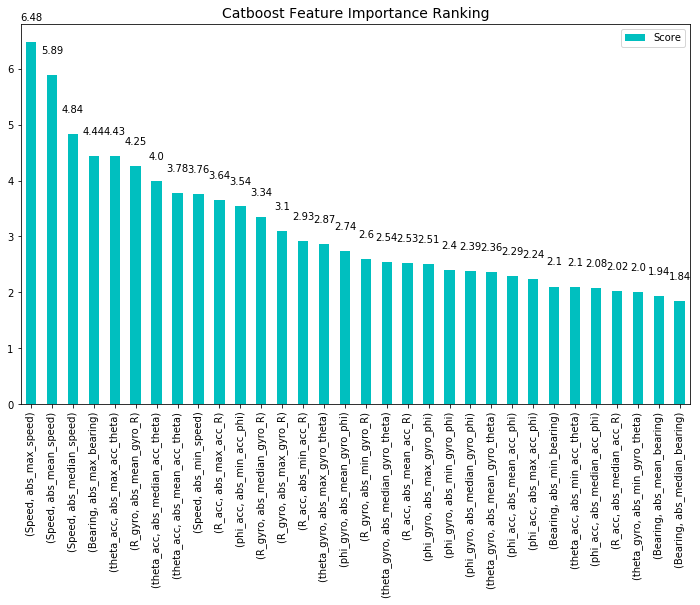

In [264]:
plt.rcParams["figure.figsize"] = (12,7)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')

rects = ax.patches

labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()


/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


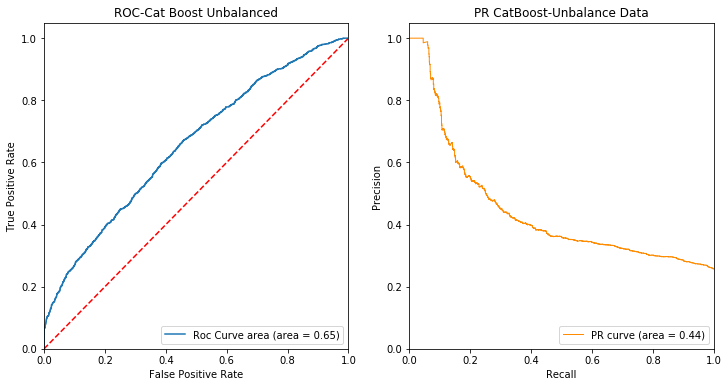

In [260]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

model_pred_1=model.predict_proba(booking_test_data)[:,1]
catboost_unbalance_roc_auc = roc_auc_score(booking_test_label, model_pred_1)
fpr_unbalance, tpr_unbalance, thresholds_unbalance = roc_curve(booking_test_label,model_pred_1)
##ax[0].figure()
ax[0].plot(fpr_unbalance, tpr_unbalance, label='Roc Curve area (area = %0.2f)' % catboost_unbalance_roc_auc)
ax[0].plot([0, 1], [0, 1],'r--')
ax[0].set_xlim([0.0, 1.0])
ax[0].set_ylim([0.0, 1.05])
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title('ROC-Cat Boost Unbalanced')
ax[0].legend(loc="lower right")

precision_unbalance, recall_unbalance, thresholds_unbalance = precision_recall_curve(booking_test_label,model_pred_1)
area_unbalance = auc(recall_unbalance, precision_unbalance)
ax[1].plot(recall_unbalance, precision_unbalance, color='darkorange', lw=1,label='PR curve (area = %0.2f)' % area_unbalance)
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_title('PR CatBoost-Unbalance Data')
ax[1].legend(loc="lower right")

fig.show()

In [205]:
booking_train_data_copy=booking_train_data
booking_train_data_copy['score']=model.predict_proba(booking_train_data)[:,1]
booking_train_data_copy['label']=booking_train['label']

In [206]:
booking_train_data_copy.head(10)

,"(R_acc, abs_min_acc_R)","(R_acc, abs_max_acc_R)","(R_acc, abs_mean_acc_R)","(R_acc, abs_median_acc_R)","(phi_acc, abs_min_acc_phi)","(phi_acc, abs_max_acc_phi)","(phi_acc, abs_mean_acc_phi)","(phi_acc, abs_median_acc_phi)","(theta_acc, abs_min_acc_theta)","(theta_acc, abs_max_acc_theta)",...,"(phi_gyro, abs_min_gyro_phi)","(phi_gyro, abs_max_gyro_phi)","(phi_gyro, abs_mean_gyro_phi)","(phi_gyro, abs_median_gyro_phi)","(theta_gyro, abs_min_gyro_theta)","(theta_gyro, abs_max_gyro_theta)","(theta_gyro, abs_mean_gyro_theta)","(theta_gyro, abs_median_gyro_theta)",score,label
11511,7.680602,12.129068,9.690536,9.674583,0.838469,1.516627,1.206918,1.208082,0.000230,0.310102,...,0.003206,1.569348,0.946376,1.040968,0.000893,1.542593,0.628572,0.619458,0.588981,1
3754,6.516558,14.092724,9.929285,9.886746,0.646851,1.550907,1.117761,1.129053,0.000000,0.436074,...,0.011785,1.570414,1.031134,1.147202,0.000981,1.527517,0.673666,0.683243,0.139660,0
12599,7.841016,12.645307,9.960839,9.939650,1.237785,1.570548,1.493242,1.508677,0.000277,0.406489,...,0.000000,1.569882,0.912729,0.963933,0.000000,1.473324,0.529410,0.479389,0.112101,0
7304,6.201478,13.766522,9.768440,9.724474,1.072921,1.569666,1.468189,1.489240,0.000200,0.353102,...,0.001974,1.570796,1.020562,1.156509,0.003573,1.504996,0.680827,0.652477,0.142703,1
13006,8.197391,12.212782,10.035750,10.019174,0.880381,1.373376,1.128026,1.128032,0.000358,0.438865,...,0.000000,1.569186,0.816518,0.849370,0.000291,1.541747,0.529488,0.430887,0.238787,0
5765,6.856922,16.098033,9.952741,9.940064,0.109270,1.569880,1.369847,1.379307,0.000057,0.482770,...,0.001046,1.567218,0.835439,0.871700,0.000766,1.554403,0.742381,0.767025,0.236110,0
15952,6.514276,13.635661,10.087800,10.005160,0.781348,1.564474,1.143273,1.142017,0.000449,0.325661,...,0.002984,1.569798,1.020190,1.130369,0.002081,1.545463,0.535786,0.482404,0.205657,0
7979,7.219030,13.015991,9.871570,9.796145,1.111193,1.568339,1.434048,1.443027,0.000000,0.374293,...,0.061338,1.567927,1.079602,1.130923,0.000188,1.344492,0.263182,0.159160,0.103053,0
2733,7.588761,15.994282,9.813299,9.774821,0.473631,1.345290,0.969067,0.961429,0.001328,0.378953,...,0.007168,1.564902,0.696270,0.651893,0.006965,1.516658,0.637094,0.614032,0.172372,0
5278,8.074437,13.757117,10.386960,10.334511,1.058513,1.570049,1.471268,1.488040,0.000025,0.365971,...,0.000000,1.570796,1.067349,1.263459,0.001302,1.547334,0.609862,0.574020,0.194271,0


In [212]:
booking_train_data_copy_analysis=booking_train_data_copy[booking_train_data_copy['label']==0].sort_values(by=['score'])
 

In [213]:
booking_train_data_copy_analysis.head(10).transpose()

,8757,11859,19694,1223,11768,17917,4993,2638,8711,6088
"(R_acc, abs_min_acc_R)",8.545019,7.537380,8.701114,7.721492,8.406239,5.930581,9.271612,8.565222,7.670083,3.374676
"(R_acc, abs_max_acc_R)",11.773289,12.531682,11.465339,11.815525,11.649738,16.064532,11.020383,12.829346,11.833972,14.503274
"(R_acc, abs_mean_acc_R)",10.176260,10.201816,9.887004,10.020456,10.004878,9.714374,9.915013,9.917907,9.873478,10.165643
"(R_acc, abs_median_acc_R)",10.178127,10.128252,9.868082,10.016586,9.991819,9.675517,9.892431,9.897848,9.911665,10.072534
"(phi_acc, abs_min_acc_phi)",1.391709,1.317455,1.282060,0.253280,0.687102,0.000687,0.725884,1.052644,1.037970,0.909754
"(phi_acc, abs_max_acc_phi)",1.569948,1.570762,1.569053,0.744504,1.102448,1.320119,1.042726,1.527342,1.316773,1.507231
"(phi_acc, abs_mean_acc_phi)",1.538979,1.491091,1.468983,0.536153,0.918377,0.119380,0.867413,1.304138,1.205515,1.219602
"(phi_acc, abs_median_acc_phi)",1.544938,1.499167,1.468964,0.536138,0.917566,0.081284,0.861603,1.309099,1.207135,1.223023
"(theta_acc, abs_min_acc_theta)",0.000108,0.000488,0.000000,0.000115,0.000029,0.000000,0.000575,0.043314,0.000410,0.000053
"(theta_acc, abs_max_acc_theta)",0.141865,0.246920,0.201803,0.168587,0.177471,0.678465,0.149191,0.517101,0.221833,0.631983


In [214]:
booking_train_data_copy[booking_train_data_copy['label']==0].describe()

,"(R_acc, abs_min_acc_R)","(R_acc, abs_max_acc_R)","(R_acc, abs_mean_acc_R)","(R_acc, abs_median_acc_R)","(phi_acc, abs_min_acc_phi)","(phi_acc, abs_max_acc_phi)","(phi_acc, abs_mean_acc_phi)","(phi_acc, abs_median_acc_phi)","(theta_acc, abs_min_acc_theta)","(theta_acc, abs_max_acc_theta)",...,"(phi_gyro, abs_min_gyro_phi)","(phi_gyro, abs_max_gyro_phi)","(phi_gyro, abs_mean_gyro_phi)","(phi_gyro, abs_median_gyro_phi)","(theta_gyro, abs_min_gyro_theta)","(theta_gyro, abs_max_gyro_theta)","(theta_gyro, abs_mean_gyro_theta)","(theta_gyro, abs_median_gyro_theta)",score,label
count,9904.000000,9904.000000,9904.000000,9904.000000,9904.000000,9904.000000,9904.000000,9904.000000,9904.000000,9904.000000,...,9904.000000,9904.000000,9904.000000,9904.000000,9904.000000,9904.000000,9904.000000,9904.000000,9904.000000,9904.0
mean,6.751167,13.900762,9.874339,9.830576,0.861245,1.518675,1.306892,1.316514,0.004786,0.476546,...,0.006008,1.568569,0.941373,1.005788,0.001875,1.522722,0.591620,0.550730,0.198219,0.0
std,1.396900,3.023969,1.111894,1.105676,0.310832,0.146150,0.242756,0.252680,0.056710,0.208954,...,0.011974,0.007348,0.136819,0.194925,0.007066,0.043087,0.131311,0.180582,0.091975,0.0
min,0.005074,1.116621,0.973050,0.971356,0.000000,0.122394,0.040212,0.019719,0.000000,0.027972,...,0.000000,0.994548,0.108515,0.043074,0.000000,0.790203,0.146269,0.056799,0.000099,0.0
25%,6.115650,12.495680,9.790201,9.753501,0.732625,1.555289,1.228221,1.231564,0.000014,0.354599,...,0.000530,1.568253,0.849285,0.878549,0.000176,1.509416,0.501475,0.420500,0.136225,0.0
50%,6.905708,13.382289,9.863576,9.820442,0.929160,1.569872,1.388807,1.399390,0.000124,0.425857,...,0.002656,1.569809,0.940222,1.017240,0.000831,1.533911,0.587469,0.535018,0.193344,0.0
75%,7.550560,14.607122,9.935679,9.886404,1.078674,1.570582,1.465003,1.484190,0.000353,0.527434,...,0.006881,1.570603,1.034655,1.147332,0.002043,1.549856,0.681031,0.671882,0.255486,0.0
max,34.317899,88.527242,40.030455,39.686074,1.421408,1.570796,1.542943,1.563240,1.219627,1.570359,...,0.310436,1.570796,1.437635,1.522986,0.423431,1.570742,1.268441,1.420744,0.925955,0.0


In [215]:
booking_train_data_copy[booking_train_data_copy['label']==1].describe()

,"(R_acc, abs_min_acc_R)","(R_acc, abs_max_acc_R)","(R_acc, abs_mean_acc_R)","(R_acc, abs_median_acc_R)","(phi_acc, abs_min_acc_phi)","(phi_acc, abs_max_acc_phi)","(phi_acc, abs_mean_acc_phi)","(phi_acc, abs_median_acc_phi)","(theta_acc, abs_min_acc_theta)","(theta_acc, abs_max_acc_theta)",...,"(phi_gyro, abs_min_gyro_phi)","(phi_gyro, abs_max_gyro_phi)","(phi_gyro, abs_mean_gyro_phi)","(phi_gyro, abs_median_gyro_phi)","(theta_gyro, abs_min_gyro_theta)","(theta_gyro, abs_max_gyro_theta)","(theta_gyro, abs_mean_gyro_theta)","(theta_gyro, abs_median_gyro_theta)",score,label
count,3309.000000,3309.000000,3309.000000,3309.000000,3309.000000,3309.000000,3309.000000,3309.000000,3309.000000,3309.000000,...,3309.000000,3309.000000,3309.000000,3309.000000,3309.000000,3309.000000,3309.000000,3309.000000,3309.000000,3309.0
mean,6.314529,15.673783,9.903725,9.820267,0.747748,1.524798,1.251218,1.260159,0.004769,0.573520,...,0.004215,1.569074,0.932421,0.993770,0.001267,1.528518,0.587583,0.545329,0.406510,1.0
std,1.526089,7.634433,0.666591,0.609707,0.375665,0.138921,0.302061,0.317727,0.057425,0.308219,...,0.007752,0.004386,0.138939,0.199233,0.002032,0.040315,0.131136,0.180932,0.205265,0.0
min,0.006008,1.211728,0.997416,0.993224,0.000000,0.278022,0.050428,0.027434,0.000000,0.120538,...,0.000000,1.390537,0.219818,0.083141,0.000000,0.606632,0.131306,0.053002,0.040305,1.0
25%,5.677685,12.813178,9.799574,9.755698,0.577269,1.558784,1.157637,1.171630,0.000000,0.382923,...,0.000382,1.568752,0.842378,0.864876,0.000122,1.516639,0.499122,0.418709,0.270210,1.0
50%,6.632076,13.811870,9.873480,9.824170,0.853058,1.569914,1.365817,1.375985,0.000108,0.467808,...,0.001998,1.569994,0.930883,1.002539,0.000618,1.538549,0.579282,0.524192,0.350806,1.0
75%,7.303939,15.390869,9.961251,9.894637,1.027105,1.570606,1.457928,1.476795,0.000275,0.623204,...,0.005195,1.570666,1.024757,1.136981,0.001602,1.552279,0.676230,0.667488,0.472741,1.0
max,18.080208,115.152244,39.810036,39.375107,1.398921,1.570796,1.530895,1.555150,1.134061,1.568489,...,0.170886,1.570796,1.375511,1.486466,0.027133,1.570470,1.188293,1.317932,0.998277,1.0
